# The Lorenz-96 and its GCM Analog

Following from the [previous notebook](https://m2lines.github.io/L96_demo/notebooks/L96-two-scale-description.html#) describing the two time-scale L96 model, now we introduce a single time-scale version of the L96 model. In this model the effects of the fast time-scale variables are missing and need to be parameterized. 
In this book the two time-scale model is an analog for the 'real world' and the single time-scale model is an analog for a general circulation model (GCM) that tries to model this 'real world'. 


## The two-timescale model: real world

We will first describe a simulation with the two time-scale model from the {doc}`L96-two-scale-description`, which is taken as the control simulation that we hope to replicate with the single time-scale model. The forcing and resolution parameters, $F$, $J$ and $K$, for the two time-scale model are fixed based on {cite:t}`Wilks2005`, as $F=18$ or $20$, $K=8$, and $J=32$. Here, the value chosen for the parameter $F$ is set large enough to ensure chaotic behavior. We also use the reference values for the $h$, $b$ and $c$ parameters to be, $h=1$, $b=10$, and $c=10$.
With this particular choice of parameter values, one model time unit (MTU) is approximately equivalent to five atmospheric days. This estimate is obtained by comparing error-doubling times in the Lorenz-96 model and the real atmosphere {cite:p}`Lorenz1995`.

In the following code, we solve the L96 system using an accurate time-stepping scheme (RK4 with sufficiently small $\Delta t$), and plot the time evolution for the $X_k$ and $Y_{j,k}$ variables.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from L96_model import L96
from L96_model import L96_eq1_xdot

In [2]:
np.random.seed(23)
W = L96(8, 32)

%time X,Y,t = W.run(0.01, 20.)

CPU times: user 3.6 s, sys: 64.5 ms, total: 3.66 s
Wall time: 3.78 s


Here is the full solution:

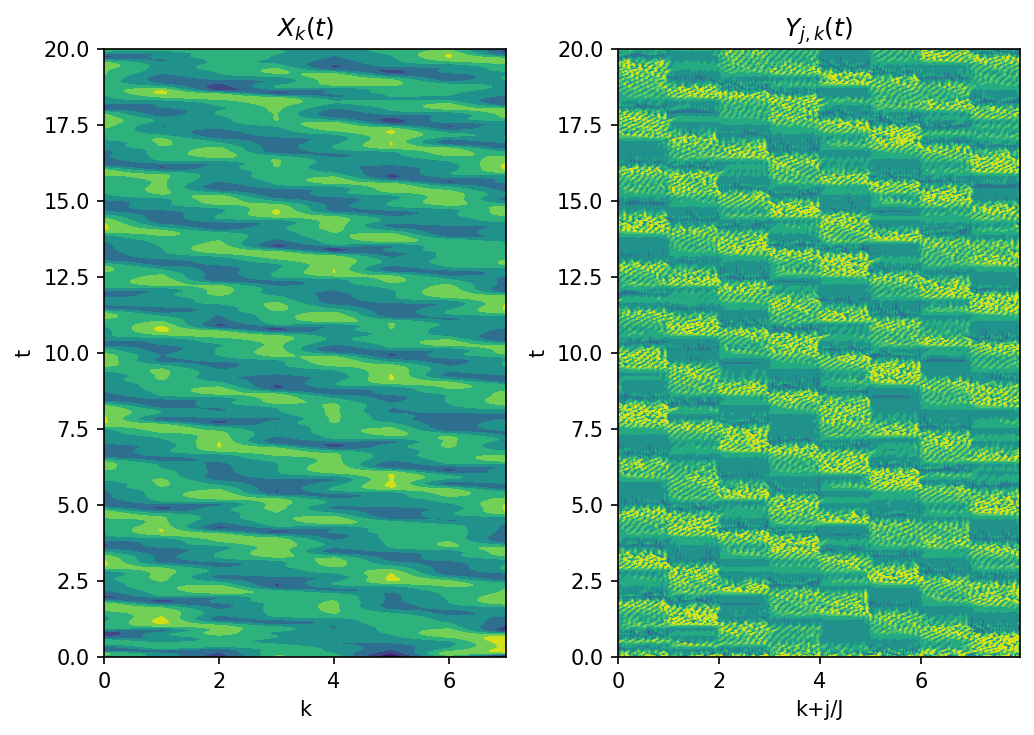

In [4]:
plt.figure(figsize=(7,5),dpi=150)

plt.subplot(121)
plt.contourf(W.k, t, X)
plt.xlabel("k")
plt.ylabel("t")
plt.title("$X_k(t)$");

plt.subplot(122)
plt.contourf(W.j / W.J, t, Y, levels=np.linspace(-1, 1, 10))
plt.xlabel("k+j/J")
plt.ylabel("t")
plt.title("$Y_{j,k}(t)$")

plt.tight_layout()

and the solution over a part of the time (zoom

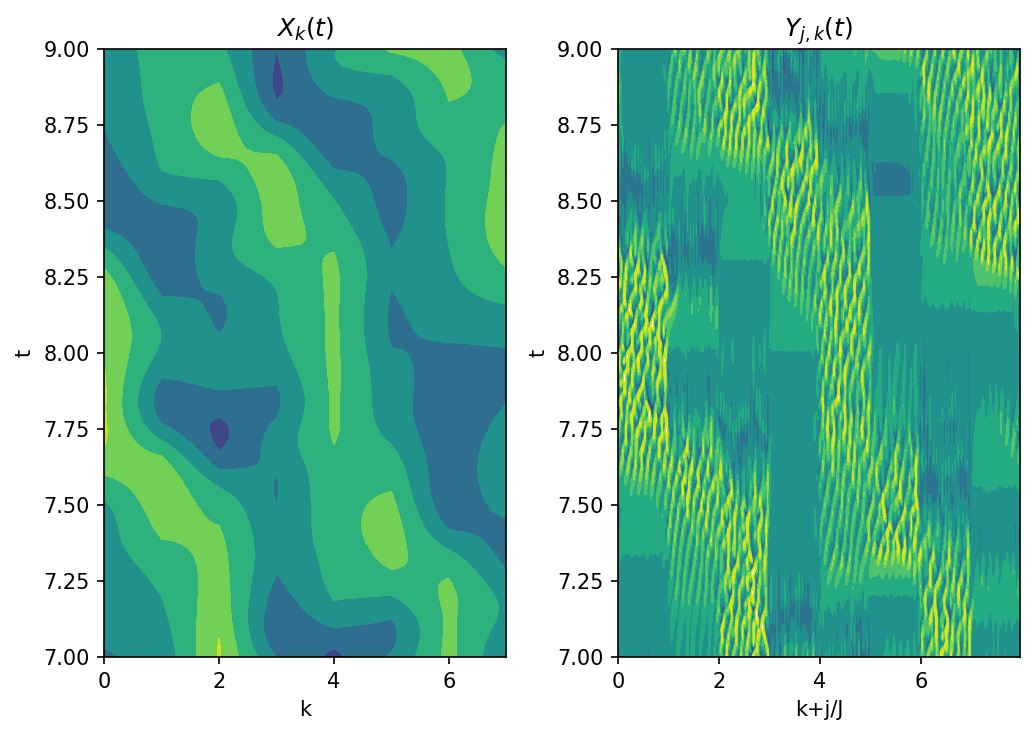

In [5]:
plt.figure(figsize=(7,5),dpi=150)

plt.subplot(121)
plt.contourf(W.k, t, X)
plt.xlabel("k")
plt.ylabel("t")
plt.title("$X_k(t)$");
yl = plt.ylim(7, 9);

plt.subplot(122)
plt.contourf(W.j / W.J, t, Y, levels=np.linspace(-1, 1, 10))
plt.xlabel("k+j/J")
plt.ylabel("t")
plt.title("$Y_{j,k}(t)$")
plt.ylim(yl);

plt.tight_layout()

## Analog for a general circulation model (GCM)

 The physical equations of motion of the system describing the atmosphere dynamics are known. However, it is not feasible to explicitly solve these equations within the Global Climate Models (GCM) due to the unresolved smallest scales and limited computational resources. Given this constraint for GCM, the two time-scale Lorenz-96 system is commonly treated as the full (or "truth") model, while a forecast (or an approximate) model is constructed by replacing the coupling terms between the slow and fast variables ($\left( \frac{hc}{b} \right) \sum_{j=0}^{J-1} Y_{j,k}$) with a sub-grid parameterization tendency that we note $U_k$, $k=1,\ldots,k$. This one time-scale Lorenz-96 equation (as it only solves for $X_k$s) corresponding to such an approximate model can be expressed as follows:

\begin{align}
\frac{d}{dt} X_k
&= - X_{k-1} \left( X_{k-2} - X_{k+1} \right) - X_k + F - \underbrace{ 
\left( \frac{hc}{b} \right) \sum_{j=0}^{J-1} Y_{j,k}
}_{=U_k} \ .
\end{align}

## The parametization $P(X_k)$

We consider the particular choice of modeling the unknown parameterization of the "unresolved processes" with a plynomial approximation such that the one time-scale equation of the Lorenz-96 model can be written as:
\begin{align}
\frac{d}{dt} X_k
&= - X_{k-1} \left( X_{k-2} - X_{k+1} \right) - X_k + F - P\left( X_k \right) \ .
\end{align}
**NOTE**: $U_k$ is a function of $Y$ while $P(X_k)$ is only based on the values of $X_i$ and has no dependency on $Y$.
The sign of the slope of $P(X_k)$ determines the sign of the feedback.

Examples of such a parameterization include the form proposed by
[Wilks (2005)](https://rmets.onlinelibrary.wiley.com/doi/abs/10.1256/qj.04.03): $P(X_k)=b_0 + b_1 X_k + b_2 X_k^2 + b_3 X_k^3 + b_4 X_k^4 + e_k$ where $e_k$ is a stochastic component. One could also use a lower-order polynomial as suggested by
[Arnold (2013)](https://royalsocietypublishing.org/doi/10.1098/rsta.2011.0479): $P(X_k)=b_0 + b_1 X_k + b_2 X_k^2 + b_3 X_k^3 + e_k$.

With the "real world" system in hand, we can "observe" the sub-grid forcing on the large scale and we model the actual coupling, $U_k$, with the polynomial function $P(X_k)$.

In the following code, we solve the one time-scale Lorenz-96 system using an inaccurate time-stepping (Euler-forward with only-just stable $\Delta t$) and an unknown parameterization of the "unresolved processes", $P(X_k)$.

In [6]:
%time X, Y, t = W.run(0.05, 200.)

CPU times: user 12.2 s, sys: 0 ns, total: 12.2 s
Wall time: 12.2 s


In [7]:
X_copy = X
U_sample = (W.h * W.c / W.b) * Y.reshape((Y.shape[0], W.K, W.J)).sum(axis=-1)
p = np.polyfit(X_copy.flatten(), U_sample.flatten(), 1)
print("Poly coeffs:", p)

Poly coeffs: [0.85439536 0.75218026]


We now compare the results obtained with a linear polynomial approximation, [Wilks (2005)'](https://rmets.onlinelibrary.wiley.com/doi/abs/10.1256/qj.04.03) polynomial parameterization and the "truth" values of the coupling terms.

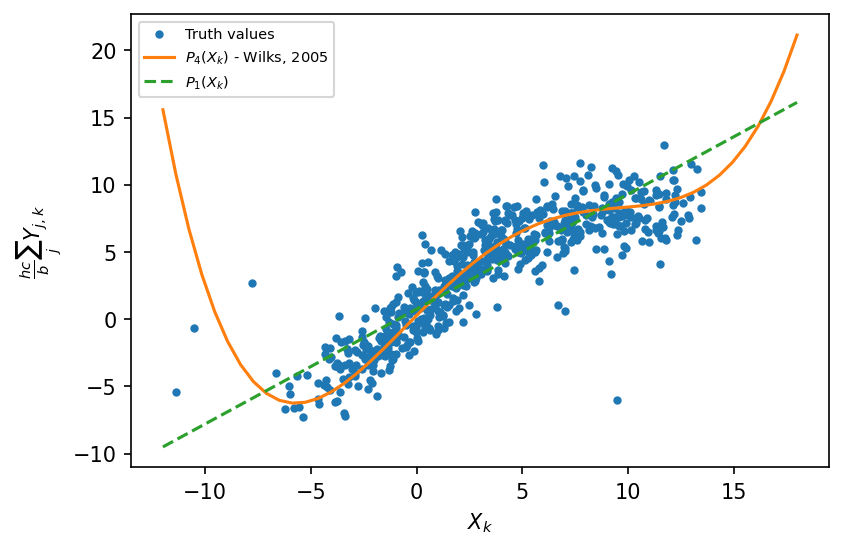

In [8]:
plt.figure(dpi=150)
plt.plot(
    X_copy[::50, :].flatten(), U_sample[::50, :].flatten(), ".", label="Truth values"
)
plt.xlabel("$X_k$")
plt.ylabel(r"$\frac{hc}{b}\sum_j Y_{j,k}$")
x = np.linspace(-12, 18)
p18 = [0.000707, -0.0130, -0.0190, 1.59, 0.275]  # Polynomial from Wilks, 2005
plt.plot(x, np.polyval(p18, x), label="$P_4(X_k)$ - Wilks, 2005")
plt.plot(x, np.polyval(p, x), "--", label="$P_1(X_k)$")
plt.legend(fontsize=7);

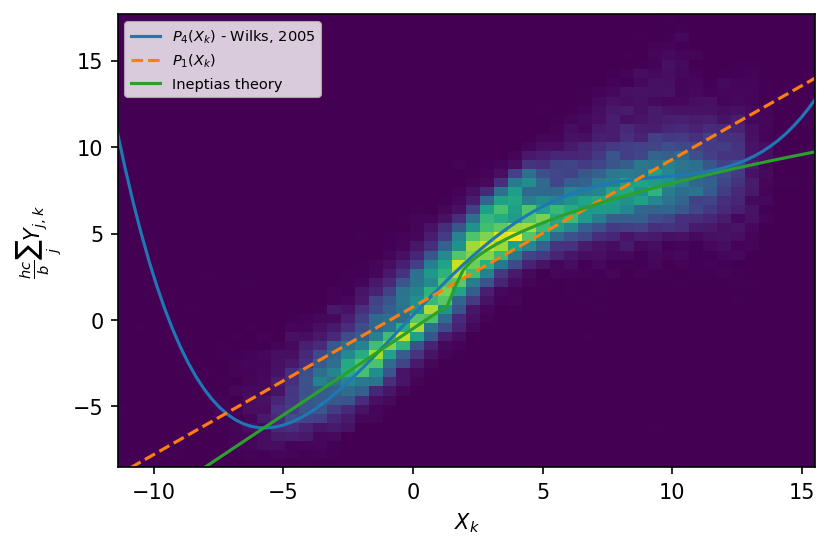

In [9]:
plt.figure(dpi=150)
plt.hist2d(X_copy.flatten(), U_sample.flatten(), bins=50)
plt.xlabel("$X_k$")
plt.ylabel(r"$\frac{hc}{b}\sum_j Y_{j,k}$")
x = np.linspace(-12, 18, 100)
p18 = [0.000707, -0.0130, -0.0190, 1.59, 0.275]  # Polynomial from Wilks, 2005
plt.plot(x, np.polyval(p18, x), label="$P_4(X_k)$ - Wilks, 2005")
plt.plot(x, np.polyval(p, x), "--", label="$P_1(X_k)$")
plt.plot(
    x,
    np.minimum(1.5, x - 0.5) + 2.2 * np.sqrt(np.maximum(0, x - 1.5)),
    label="Ineptias theory",
)
plt.legend(fontsize=7);

## The "GCM" model

Next, we compare the predictions obtained with the different models: 
- "Real world": corresponding to the "truth" model goverened by the full two time-scale Lorenz-96 system.
- GCM without parameterization: corresponding to the one time-scale Lorenz-96 system without any the coupling term. We use a forward-Euler scheme to integrate the model forward.
- GCM with our parameterization: corresponding to the one time-scale Lorenz-96 system with the linear polynomial approximation of the coupling terms as obtained above.
- GCM with [Wilks (2005)](https://rmets.onlinelibrary.wiley.com/doi/abs/10.1256/qj.04.03) parameterization: corresponding to the one time-scale Lorenz-96 system with a third-order polynomial approximation of the coupling terms.

In [10]:
def GCM(X0, F, dt, nt, param=[0]):
    time, hist, X = dt * np.arange(nt), np.zeros((nt, len(X0))) * np.nan, X0.copy()

    for n in range(nt):
        X = X + dt * (L96_eq1_xdot(X, F) - np.polyval(param, X))
        if np.abs(X).max() > 1e3:
            break
        hist[n], time[n] = X, dt * (n + 1)
    return hist, time

In [11]:
np.random.seed(13)
T = 5
X_true, Y_true, T_true = W.randomize_IC().run(0.05, T)
X_init, dt, F_mod = X_true[0] + 0.0 * np.random.randn(W.K), 0.002, W.F + 0.0
X_gcm1, T_gcm1 = GCM(X_init, F_mod, dt, int(T / dt))
X_gcm2, T_gcm2 = GCM(X_init, F_mod, dt, int(T / dt), param=p)
X_gcm3, T_gcm3 = GCM(X_init, F_mod, dt, int(T / dt), param=p18)

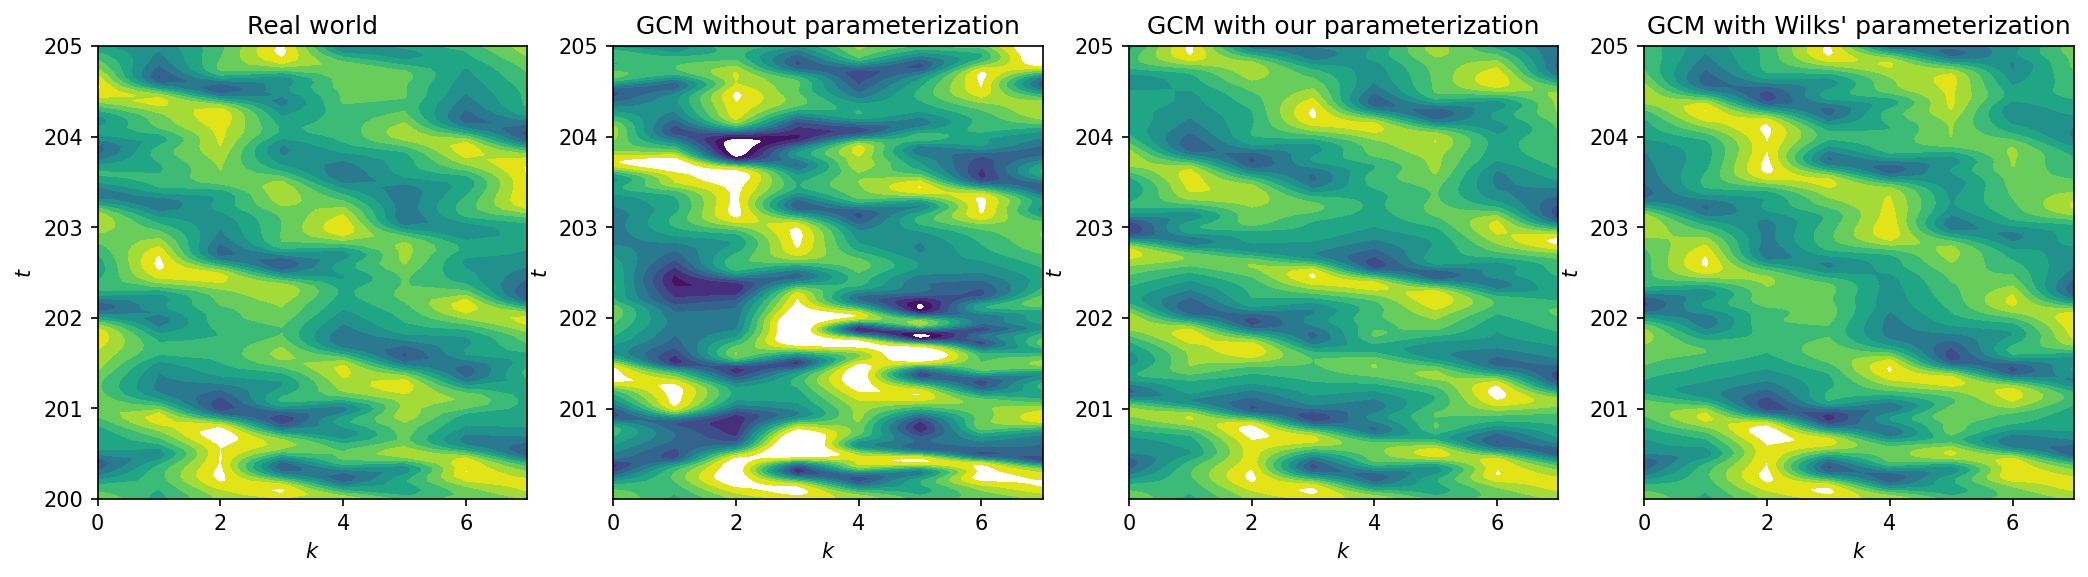

In [12]:
plt.figure(dpi=150, figsize=(17, 4))
lims = {"vmin": -12, "vmax": 12, "levels": np.linspace(-12, 12, 12)}
plt.subplot(141)
plt.contourf(W.k, T_true + t[-1], X_true, **lims)
plt.xlabel("$k$")
plt.ylabel("$t$")
plt.title("Real world")
plt.subplot(142)
plt.contourf(W.k, T_gcm1 + t[-1], X_gcm1, **lims)
plt.xlabel("$k$")
plt.ylabel("$t$")
plt.title("GCM without parameterization")
plt.subplot(143)
plt.contourf(W.k, T_gcm3 + t[-1], X_gcm2, **lims)
plt.xlabel("$k$")
plt.ylabel("$t$")
plt.title("GCM with our parameterization")
plt.subplot(144)
plt.contourf(W.k, T_gcm2 + t[-1], X_gcm3, **lims)
plt.xlabel("$k$")
plt.ylabel("$t$")
plt.title("GCM with Wilks' parameterization");

The next plot shows the temporal evolution of the variable $X_3$ obtained with the four models listed above.

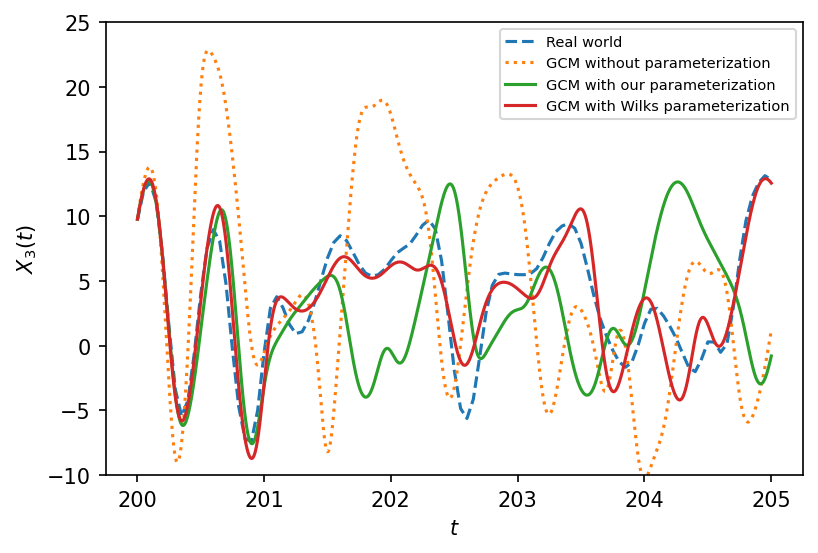

In [13]:
k = 3
plt.figure(dpi=150)
plt.plot(T_true + t[-1], X_true[:, k], "--", label="Real world")
plt.plot(T_gcm1 + t[-1], X_gcm1[:, k], ":", label="GCM without parameterization")
plt.plot(T_gcm1 + t[-1], X_gcm2[:, k], label="GCM with our parameterization")
plt.plot(T_gcm1 + t[-1], X_gcm3[:, k], label="GCM with Wilks parameterization")
plt.xlabel("$t$")
plt.ylabel("$X_3(t)$")
plt.legend(fontsize=7, loc=1)
plt.ylim(-10, 25);

## Model error

We consider the following five sources of error:

1. Missing physics: which is modeled with a GCM without parameterization that corresponds to the one time-scale Lorenz-96 system without any the coupling term.
2. Poorly parameterized unresolved physics: which is studied by considering a first-order and third-order polynomial approximations of the coupling terms:
    \begin{equation*}
    P_4 \rightarrow P_1
    \end{equation*}
3. Unknown forcing: which is modeled by adding an error to the forcing term:
    \begin{equation*}
    F \rightarrow F + error
    \end{equation*}
4. Numerical approximation: which is studied by increasing the time-step:
    \begin{equation*}
    \Delta t \rightarrow 10 \Delta t
    \end{equation*}
5. Initialization error: which is modeled by adding an error to the initial condition:
    \begin{equation*}
    X(t=0) \rightarrow X(t=0) + error
    \end{equation*}
  
The next code estimates these sources of error and the next figure shows their relative contributions. For reference, we also plot the error of the GCM using [Wilks (2005)](https://rmets.onlinelibrary.wiley.com/doi/abs/10.1256/qj.04.03)' polynomial coupling term and without any of the sources of error listed above. All errors are evaluated by comparing the GCMs to the "truth" model goverened by the full two time-scale Lorenz-96 system.

In [14]:
def err(X, X_true):
    return np.sqrt(((X - X_true[1:, :]) ** 2).mean(axis=1))

In [15]:
np.random.seed(13)
T, dt = 2, 0.001
X_tr, _, _ = W.randomize_IC().set_param(0.0001).run(dt, T)
X_gcm, T_c = GCM(W.X, W.F, dt, int(T / dt), param=p18)
X_frc, T_c = GCM(W.X, W.F + 1.0, dt, int(T / dt), param=p18)
X_ic, T_c = GCM(W.X + 0.5, W.F, dt, int(T / dt), param=p18)
X_dt, T_dt = GCM(W.X, W.F, 10 * dt, int(T / dt / 10), param=p18)
X_phys, _ = GCM(W.X, W.F, dt, int(T / dt))
X_prm, _ = GCM(W.X, W.F, dt, int(T / dt), param=p)

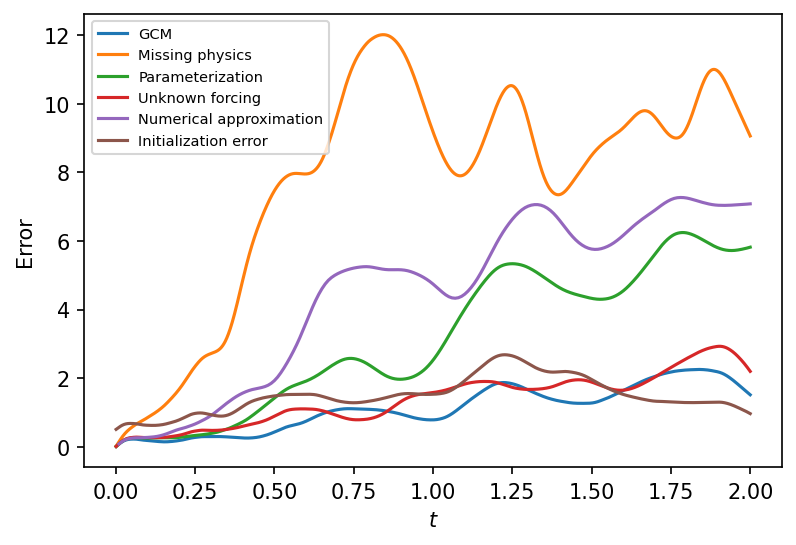

In [16]:
plt.figure(dpi=150)
plt.plot(T_c, err(X_gcm, X_tr), label="GCM")
plt.plot(T_c, err(X_phys, X_tr), label="Missing physics")
plt.plot(T_c, err(X_prm, X_tr), label="Parameterization")
plt.plot(T_c, err(X_frc, X_tr), label="Unknown forcing")
plt.plot(T_dt, err(X_dt, X_tr[::10]), label="Numerical approximation")
plt.plot(T_c, err(X_ic, X_tr), label="Initialization error")
plt.xlabel("$t$")
plt.ylabel("Error")
plt.legend(fontsize=7);

For this particular set of parameter values, the removal of the coupling term results in the highest error. The second and third sources of error correspond to the numerical error (introduced by increasing the time-step) and to the error resulting form poorly parameterized unresolved physics (modeled by consideing a first-order polynomial approximation of the coupling terms) respectively.

The errors introduced by an unknown forcing and a different initialization are the least among the sources of errors considered.

Next, we run the following two variations of two time-scale Lorenz-96:
1. The GCM with our parameterization corresponding to the one time-scale Lorenz-96 system, with the linear polynomial approximation of the coupling terms.
2. The GCM with [Wilks (2005)'](https://rmets.onlinelibrary.wiley.com/doi/abs/10.1256/qj.04.03) parameterization corresponding to the one time-scale Lorenz-96 system with a third-order polynomial approximation of the coupling terms.

In [17]:
# Build a 100-"day" climatology

T, dt = 100.0, 0.001
%time X_clim,Y_clim,T_clim = W.run(0.1, T)
%time X1,t1 = GCM(X_init, F_mod, dt, int(T/dt), param=p)
%time X2,t2 = GCM(X_init, F_mod, dt, int(T/dt), param=p18)

CPU times: user 1min 1s, sys: 0 ns, total: 1min 1s
Wall time: 1min 1s
CPU times: user 1.84 s, sys: 46.3 ms, total: 1.89 s
Wall time: 1.85 s
CPU times: user 2.54 s, sys: 8.94 ms, total: 2.55 s
Wall time: 2.55 s


We compare the mean values of the slow variables $X_k$ , $k=1,\ldots,K$.

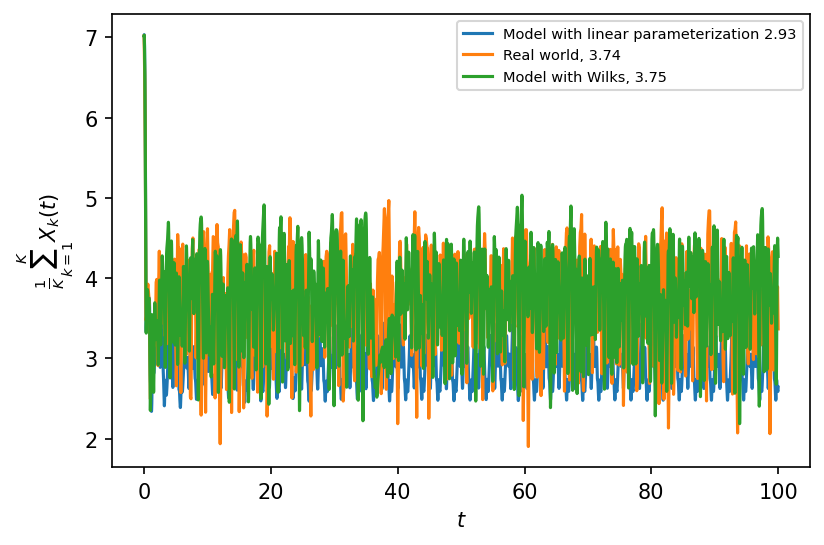

In [18]:
plt.figure(dpi=150)
plt.plot(
    t1, X1.mean(axis=1), label="Model with linear parameterization %.2f" % (X1.mean())
)
plt.plot(T_clim, X_clim.mean(axis=1), label="Real world, %.2f" % (X_true.mean()))
plt.plot(t2, X2.mean(axis=1), label="Model with Wilks, %.2f" % (X2.mean()))
plt.xlabel("$t$")
plt.ylabel(r"$\frac{1}{K}\sum_{k=1}^K X_k(t)$")
plt.legend(fontsize=7)

In [19]:
print("\n\n       Truth      P1   Wilks")
print("mean:  %.3f   %.3f   %.3f" % (X_true.mean(), X1.mean(), X2.mean()))
print("std:   %.3f   %.3f   %.3f" % (X_true.std(), X1.std(), X2.std()))



       Truth      P1   Wilks
mean:  3.741   2.926   3.750
std:   4.679   4.375   4.524


As expected, the [Wilks (2005)](https://rmets.onlinelibrary.wiley.com/doi/abs/10.1256/qj.04.03)' parameterization gives a mean value of the slow variables that is closer to the one obtained with the "truth" model compared to the model with linear parameterization since [Wilks (2005)'](https://rmets.onlinelibrary.wiley.com/doi/abs/10.1256/qj.04.03) coupling term is modeled with a third-order polynomial.

Next, we consider the model with the full parameterization proposed by [Wilks (2005)](https://rmets.onlinelibrary.wiley.com/doi/abs/10.1256/qj.04.03) by adding a stochastic component such that the parameterization has the following form: $P(X_k)=b_0 + b_1 X_k + b_2 X_k^2 + b_3 X_k^3 + b_4 X_k^4 + e_k$ where $e_k$ is a stochastic component.

In [20]:
def GCMs(X0, F, dt, nt, param=[0], stoch=1.0, phi=0.984):
    time, hist, X = dt * np.arange(nt), np.zeros((nt, len(X0))) * np.nan, X0.copy()
    ek = np.zeros(X.size)

    for n in range(nt):
        # Red noise
        ek = phi * ek + stoch * np.sqrt((1 - phi) * (1 + phi)) * np.random.randn(X.size)
        X = X + dt * (L96_eq1_xdot(X, F) - np.polyval(param, X) + stoch * ek)
        if np.abs(X).max() > 1e3:
            break
        hist[n], time[n] = X, dt * (n + 1)
    return hist, time

In [21]:
np.random.seed(31)
%time X3,t3 = GCMs(X_init, F_mod, dt, int(T/dt), param=p18)

print("\n\n       Truth      P1      P4  P4+stoch")
print(
    "mean:  %.3f   %.3f   %.3f   %.3f"
    % (X_true.mean(), X1.mean(), X2.mean(), X3.mean())
)
print("std:   %.3f   %.3f   %.3f   %.3f" % (X_true.std(), X1.std(), X2.std(), X3.std()))

CPU times: user 3.37 s, sys: 0 ns, total: 3.37 s
Wall time: 3.37 s


       Truth      P1      P4  P4+stoch
mean:  3.741   2.926   3.750   3.758
std:   4.679   4.375   4.524   4.537


By comparing the mean and standard deviation values of the slow variables $X_k$ , $k=1,\ldots,K$, we do not see a significant improvement when adding the stochastic component $e_k$ to the third-order polynomial parameterization.

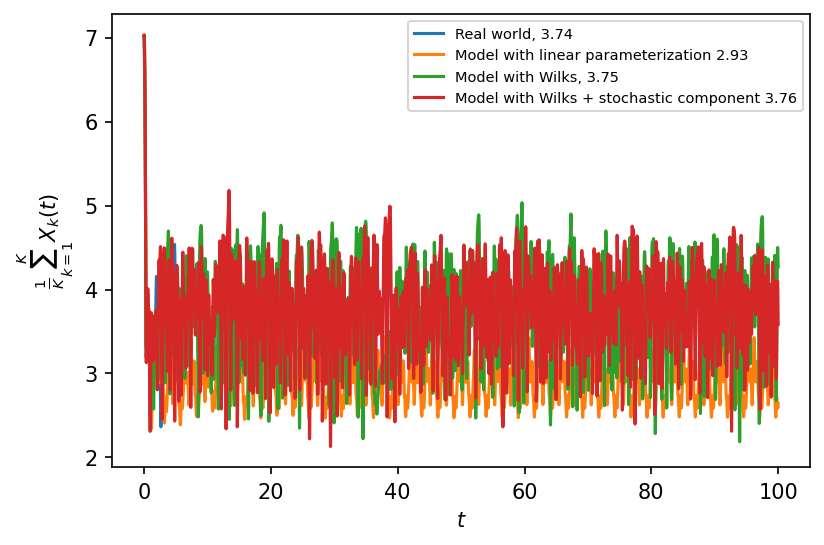

In [22]:
plt.figure(dpi=150)
plt.plot(T_true, X_true.mean(axis=1), label="Real world, %.2f" % (X_true.mean()))
plt.plot(
    t1, X1.mean(axis=1), label="Model with linear parameterization %.2f" % (X1.mean())
)
plt.plot(t2, X2.mean(axis=1), label="Model with Wilks, %.2f" % (X2.mean()))
plt.plot(
    t3,
    X3.mean(axis=1),
    label="Model with Wilks + stochastic component %.2f" % (X3.mean()),
)
plt.xlabel("$t$")
plt.ylabel(r"$\frac{1}{K}\sum_{k=1}^K X_k(t)$")
plt.legend(fontsize=7);

## Summary

In this chapter:
- We used the two time-scale Lorenz-96 model to generate a real world, or "truth", dataset
- We built a "GCM" with a rudimentary parameterization of coupling to unresolved processes ($\left( \frac{hc}{b} \right) \sum_{j=0}^{J-1} Y_{j,k}$)
- We deliberately used low-order integration and longer time-step for non-trivial numerical model errors.
- We compared the different sources of error due to: 
  1. Missing physics
  2. Poorly parameterized unresolved physics
  3. Unknown forcing
  4. Time-discretization numerical approximation 
  5. Initialization error.
- We also compared the results obtained:
  1. A GCM corresponding to the one time-scale Lorenz-96 system with a linear polynomial parameterization of the coupling terms.
  2. A GCM with [Wilks (2005)'](https://rmets.onlinelibrary.wiley.com/doi/abs/10.1256/qj.04.03) parameterization corresponding to the one time-scale Lorenz-96 system with a third-order polynomial approximation of the coupling terms.
  3. A GCM with the full [Wilks (2005)'](https://rmets.onlinelibrary.wiley.com/doi/abs/10.1256/qj.04.03) parameterization corresponding to the one time-scale Lorenz-96 system with a third-order polynomial approximation of the coupling terms and a stochastic component.